In [1]:
import pandas as pd
import re
import time
from tashaphyne.stemming import ArabicLightStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import seaborn as sns
import numpy as np
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB

In [2]:
class TextCleaner:
    def __init__(self, only_english_characters=True,
                 remove_numbers=True, stemming=True,
                 remove_long_words=True, remove_links=True,
                 remove_hashtags_mentions=True):
        self.__only_english_characters=only_english_characters
        self.__remove_numbers=remove_numbers
        self.__stemming=stemming
        self.__remove_long_words=remove_long_words
        self.__remove_links=remove_links
        self.__remove_hashtags_mentions=remove_hashtags_mentions
                  
    def general_text_cleaning(self, text):
        if self.__remove_hashtags_mentions:
            text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())

        lemmatization = WordNetLemmatizer()
        newText = ''
        for word in text:
            newText += lemmatization.lemmatize(word)    
        text = newText.strip()

            
        if self.__only_english_characters:
            text = re.sub("[^A-Za-z ]", "", text)
            text = re.sub(' +', ' ', text)
        

        

        if self.__remove_numbers:
            text = re.sub('^\d+\s|\s\d+\s|\s\d+$', '', text)
            text = re.sub(' +', ' ', text)
        
        if self.__remove_links:
            text = re.sub(r'http\S+', '', text)
        
        if self.__remove_long_words:
            result = []
            textList = text.split()
            for word in textList:
                if len(word) <= 15:
                    result.append(word)

            text = ' '.join(result)
        
        if self.__stemming:
            porter = PorterStemmer()
            newText = ''
            for word in text:
                newText += porter.stem(word)
                
            text = newText.strip()
        
        stop_words = {"amp", "0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"}
        word_tokens = word_tokenize(text)
        filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
        filtered_sentence = []
 
        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w)

        text = ' '.join(filtered_sentence)


        return text
    
    def nlp_cleaning(self, df_train, df_test):
        df_train = df_train.copy()
        df_test = df_test.copy()
        
        X_train = df_train['text']
        X_test = df_test['text']
        y_train = df_train['class']
        y_test = df_test['class']
        
        vectorizer = TfidfVectorizer(sublinear_tf = True,
                                     use_idf = True)
        train_vectors = vectorizer.fit_transform(X_train)
        test_vectors = vectorizer.transform(X_test)
        
        return vectorizer, X_train, X_test, y_train, y_test, train_vectors, test_vectors
    
    
    def all_cleaning(self, df='', df_test='', purpose=''):
        df = df.copy()
        for i in range(len(df['text'])):
            text = self.general_text_cleaning(df['text'].iloc[i])
            df['text'].iloc[i] = text
        
        if purpose == 'Show statistics':
            return df
        if purpose == 'Get predictions':
            for i in range(len(df_test['text'])):
                text = self.general_text_cleaning(df_test['text'].iloc[i])
                df_test['text'].iloc[i] = text
            vectorizer, X_train, X_test, y_train, y_test, train_vectors, test_vectors = self.nlp_cleaning(df, df_test)
            return df, df_test, vectorizer, X_train, X_test, y_train, y_test, train_vectors, test_vectors

In [3]:
c1 = TextCleaner()

In [4]:
train = pd.read_csv('political_vs_normal_train.csv')
test = pd.read_csv('political_vs_normal_test.csv')

df_train = train.copy().dropna()

df_test = test.copy().dropna()

df_train, df_test, vectorizer, X_train, X_test, y_train, y_test, train_vectors, test_vectors = c1.all_cleaning(df_train, df_test, purpose = 'Get predictions')

In [5]:
df_train

,text,class
0,temptations masterpiece japan vinyl lp swx exc...,1
1,zionism determination jews unhappy determinati...,1
2,green forest alert central african republic,1
3,good communication skills crucial product mana...,1
4,french guiana direct representation french nat...,1
...,...,...
34827,scale months ago months ago,0
34828,love men smoke weed wtf sexy yummy,0
34829,idk players press button edit early,0
34830,knew looked familiar lmao,0


In [6]:
df_test

,text,class
0,russian soldiers crash foiled retreat kherson ...,1
1,alas santoses corrupt irresponsible body makin...,1
2,rlly fucked hispano latinos shit ton racism sh...,1
3,post unjust defendants pay normal consequences...,1
4,open jan dues ethics essay module commissioner...,1
...,...,...
14923,posted photo,0
14924,kind pleasure,0
14925,faith understand language,0
14926,york times laugh,0


In [7]:
classifier_svm = svm.SVC(kernel='linear', probability=True)
t0 = time.time()
classifier_svm.fit(train_vectors, y_train)
t1 = time.time()
svm_pred = classifier_svm.predict(test_vectors)
t2 = time.time()
train_time = t1-t0
predict_time = t2-t1
print("Training time: %fs; Prediction time: %fs" % (train_time, predict_time))
report = classification_report(y_test, svm_pred, output_dict=True)
print('normal: ', report['0'])
print('political: ', report['1'])

Training time: 874.168014s; Prediction time: 14.054176s
normal:  {'precision': 0.8835828600929272, 'recall': 0.9173254723301622, 'f1-score': 0.9001380579843534, 'support': 7463}
political:  {'precision': 0.9140548822955843, 'recall': 0.8791532690246516, 'f1-score': 0.8962644266885201, 'support': 7464}


In [8]:
classifier_rf = RandomForestClassifier(max_depth =6, n_estimators=1000)
t0 = time.time()
classifier_rf.fit(train_vectors, y_train)
t1 = time.time()
rf_pred = classifier_rf.predict(test_vectors)
t2 = time.time()
train_time = t1-t0
predict_time = t2-t1
print("Training time: %fs; Prediction time: %fs" % (train_time, predict_time))
report = classification_report(y_test, rf_pred, output_dict=True)
print('normal: ', report['0'])
print('political: ', report['1'])

Training time: 4.754938s; Prediction time: 0.816792s
normal:  {'precision': 0.7005813953488372, 'recall': 0.9364866675599625, 'f1-score': 0.8015367853661334, 'support': 7463}
political:  {'precision': 0.9042617652999394, 'recall': 0.5998124330117899, 'f1-score': 0.721224325412807, 'support': 7464}


In [7]:
classifier_xgb = XGBClassifier(max_depth =6, n_estimators=1000)
t0 = time.time()
classifier_xgb.fit(train_vectors, y_train)
t1 = time.time()
xgb_pred = classifier_xgb.predict(test_vectors)
t2 = time.time()
train_time = t1-t0
predict_time = t2-t1
print("Training time: %fs; Prediction time: %fs" % (train_time, predict_time))
report = classification_report(y_test, xgb_pred, output_dict=True)
print('normal: ', report['0'])
print('political: ', report['1'])

[12:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 30.581042s; Prediction time: 0.309070s
normal:  {'precision': 0.8745850239763925, 'recall': 0.9531019697172719, 'f1-score': 0.9121569633239291, 'support': 7463}
political:  {'precision': 0.948483956432146, 'recall': 0.8633440514469454, 'f1-score': 0.9039135923691962, 'support': 7464}


In [15]:
classifier_nb = GaussianNB()
t0 = time.time()
classifier_nb.fit(train_vectors.toarray(), y_train)
t1 = time.time()
nb_pred = classifier_nb.predict(test_vectors.toarray())
t2 = time.time()
train_time = t1-t0
predict_time = t2-t1
print("Training time: %fs; Prediction time: %fs" % (train_time, predict_time))
report = classification_report(y_test, nb_pred, output_dict=True)
print('normal: ', report['0'])
print('political: ', report['1'])

Training time: 92.957995s; Prediction time: 14.631092s
normal:  {'precision': 0.7491492464754497, 'recall': 0.8259413104649604, 'f1-score': 0.785673315913581, 'support': 7463}
political:  {'precision': 0.8060904612628751, 'recall': 0.7234726688102894, 'f1-score': 0.7625503071383182, 'support': 7464}


In [10]:
classifier_lgb = lgb.LGBMClassifier(max_depth =6, n_estimators=1000)
t0 = time.time()
classifier_lgb.fit(train_vectors, y_train)
t1 = time.time()
lgb_pred = classifier_lgb.predict(test_vectors)
t2 = time.time()
train_time = t1-t0
predict_time = t2-t1
print("Training time: %fs; Prediction time: %fs" % (train_time, predict_time))
report = classification_report(y_test, lgb_pred, output_dict=True)
print('normal: ', report['0'])
print('political: ', report['1'])

Training time: 3.941998s; Prediction time: 0.102023s
normal:  {'precision': 0.8538443227802904, 'recall': 0.9612756264236902, 'f1-score': 0.9043807122596912, 'support': 7463}
political:  {'precision': 0.9557088122605364, 'recall': 0.8354769560557342, 'f1-score': 0.8915576524412039, 'support': 7464}


In [11]:
ensemble_pred = []
for i in range(len(svm_pred)):
    if svm_pred[i]+lgb_pred[i]+xgb_pred[i] >= 2:
        ensemble_pred.append(1)
    else:
        ensemble_pred.append(0)

report = classification_report(y_test, ensemble_pred, output_dict=True)
print('normal: ', report['0'])
print('political: ', report['1'])

normal:  {'precision': 0.8760279857616301, 'recall': 0.9563178346509447, 'f1-score': 0.9144138372837924, 'support': 7463}
political:  {'precision': 0.9519174041297935, 'recall': 0.8646838156484459, 'f1-score': 0.9062061218758775, 'support': 7464}


In [ ]:
def predict(classifier, documents):
    if classifier == 'Ensemble':
        for document in documents:
            document_vector = vectorizer.transform([document])
            if classifier_svm.predict(document_vector)+classifier_xgb.predict(document_vector)+classifier_lgb.predict(document_vector) <= 1:
                print('Document: '+document+', Classifier says Not political,', 'probabilty of it being political:')
                print('SVM probability =',classifier_svm.predict_proba(document_vector)[0][1], 'XGBoost probability =',classifier_xgb.predict_proba(document_vector)[0][1], 'LightGBM probability =',classifier_lgb.predict_proba(document_vector)[0][1])
                print(' ')
            else:
                print('Document: '+document+', Classifier says political,', 'probabilty of it being political:')
                print('SVM probability =',classifier_svm.predict_proba(document_vector)[0][1], 'XGBoost probability =',classifier_xgb.predict_proba(document_vector)[0][1], 'LightGBM probability =',classifier_lgb.predict_proba(document_vector)[0][1])           
                print(' ')
        print(' ')
        return
        
    for document in documents:
        document_vector = vectorizer.transform([document])
        if classifier.predict(document_vector) == 0:
            print('Document: '+document+', Classifier says Not political,', 'probabilty of it being political:')
            print(classifier.predict_proba(document_vector)[0][1])
            print(' ')
        else:
            print('Document: '+document+', Classifier says political,', 'probabilty of it being political:')
            print(classifier.predict_proba(document_vector)[0][1])
            print(' ')
        print(' ')
documents = ['conflict between cats this is so funny I am so happy']
#'I love politics but my cat doesnt so I will go to the park to start a war cat cat dogs happy funny', 

print('SVM')
predict(classifier_svm, documents)

print('Random Forest')
predict(classifier_rf, documents)

print('XGBoost')
predict(classifier_xgb, documents)

print('LighGBM')
predict(classifier_lgb, documents)

print('NB')
predict(classifier_nb, documents)

print('Ensemble')
predict('Ensemble', documents)

In [18]:
def evaluate(y_test, y_pred, model_name = ''):
    print('Model:',model_name)
    cf_matrix = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, fmt='g')
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['normal', 'political']); ax.yaxis.set_ticklabels(['normal', 'political'])
    plt.show()

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    AUC = metrics.auc(fpr, tpr)

    ACCURACY = accuracy_score(y_test, y_pred)

    PRECISION = precision_score(y_test, y_pred)

    F1_SCORE = f1_score(y_test, y_pred)

    RECALL = recall_score(y_test, y_pred)

    print('Accuracy =', ACCURACY)
    print('Precision =', PRECISION)
    print('Recall =', RECALL)
    print('F1 score =', F1_SCORE)
    print('AUC =', AUC)
    print('############################################################################')
    print('')

Model: SVM


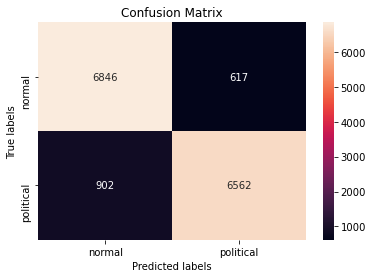

Accuracy = 0.8982380920479668
Precision = 0.9140548822955843
Recall = 0.8791532690246516
F1 score = 0.8962644266885201
AUC = 0.8982393706774068
############################################################################

Model: Random Forest


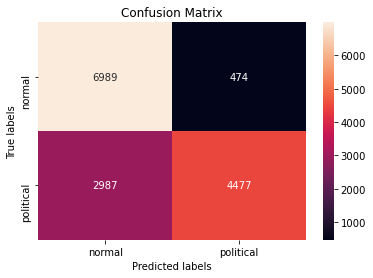

Accuracy = 0.7681382729282509
Precision = 0.9042617652999394
Recall = 0.5998124330117899
F1 score = 0.721224325412807
AUC = 0.7681495502858762
############################################################################

Model: XGBoost


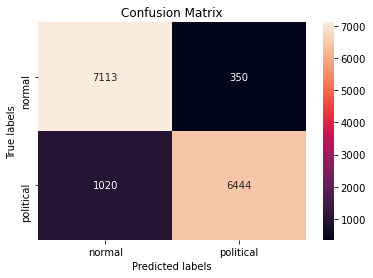

Accuracy = 0.9082200040195618
Precision = 0.948483956432146
Recall = 0.8633440514469454
F1 score = 0.9039135923691962
AUC = 0.9082230105821087
############################################################################

Model: LightGBM


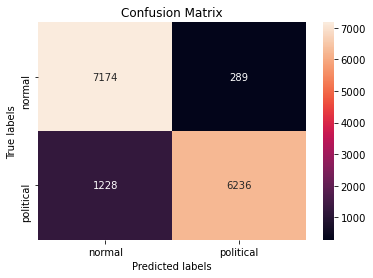

Accuracy = 0.8983720774435586
Precision = 0.9557088122605364
Recall = 0.8354769560557342
F1 score = 0.8915576524412039
AUC = 0.8983762912397122
############################################################################

Model: Ensemble


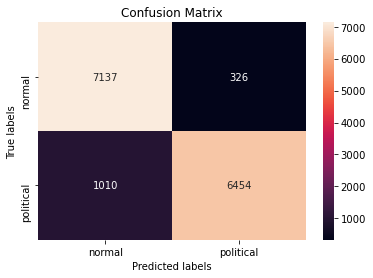

Accuracy = 0.9104977557446239
Precision = 0.9519174041297935
Recall = 0.8646838156484459
F1 score = 0.9062061218758775
AUC = 0.9105008251496953
############################################################################



In [30]:
evaluate(y_test, svm_pred, 'SVM')
evaluate(y_test, rf_pred, 'Random Forest')
evaluate(y_test, xgb_pred, 'XGBoost')
evaluate(y_test, lgb_pred, 'LightGBM')
evaluate(y_test, ensemble_pred, 'Ensemble')
evaluate(y_test, nb_pred, 'Naive Bayes')

Model: Naive Bayes


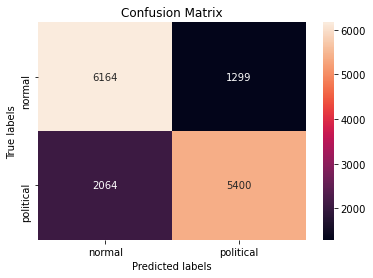

Accuracy = 0.7747035573122529
Precision = 0.8060904612628751
Recall = 0.7234726688102894
F1 score = 0.7625503071383182
AUC = 0.7747069896376249
############################################################################



In [19]:
evaluate(y_test, nb_pred, 'Naive Bayes')

In [59]:
allData = pd.concat([X_train, X_test]).reset_index().drop('index', axis=1)
allClass = pd.concat([y_train, y_test]).reset_index().drop('index', axis=1)

vectorizer2 = TfidfVectorizer(sublinear_tf = True,
                             use_idf = True)
allData_vectors = vectorizer2.fit_transform(allData['text'])

In [61]:
classifier_svm = svm.SVC(kernel='linear', probability=True)
classifier_svm.fit(allData_vectors, allClass)

SVC(kernel='linear', probability=True)

In [60]:
classifier_xgb = XGBClassifier(max_depth =6, n_estimators=1000)
classifier_xgb.fit(allData_vectors, allClass)

classifier_lgb = lgb.LGBMClassifier(max_depth =6, n_estimators=1000)
classifier_lgb.fit(allData_vectors, allClass)

[13:47:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


LGBMClassifier(max_depth=6, n_estimators=1000)

Model: SVM


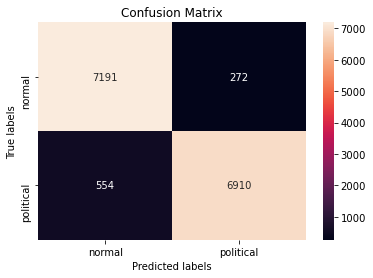

Accuracy = 0.9446640316205533
Precision = 0.9621275410749095
Recall = 0.9257770632368703
F1 score = 0.9436023487641677
AUC = 0.9446652969942894
############################################################################

Model: XGBoost


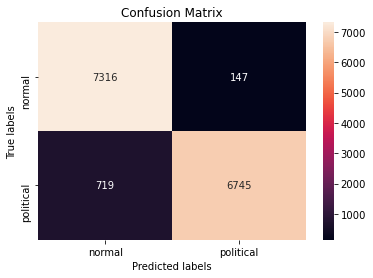

Accuracy = 0.9419843237087158
Precision = 0.978670922809054
Recall = 0.9036709539121115
F1 score = 0.9396767901922541
AUC = 0.9419868905966828
############################################################################

Model: LighGBM


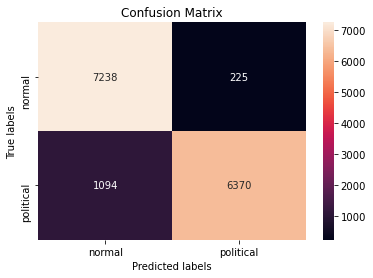

Accuracy = 0.9116366316071548
Precision = 0.9658832448824868
Recall = 0.8534297963558414
F1 score = 0.9061810939611638
AUC = 0.9116405313013296
############################################################################



In [66]:
test_vectors2 = vectorizer2.transform(X_test)

svm_pred = classifier_svm.predict(test_vectors2)
xgb_pred = classifier_xgb.predict(test_vectors2)
lgb_pred = classifier_lgb.predict(test_vectors2)

evaluate(y_test, svm_pred, 'SVM')
evaluate(y_test, xgb_pred, 'XGBoost')
evaluate(y_test, lgb_pred, 'LighGBM')

In [63]:
import pickle

In [68]:
pickle.dump(classifier_svm, open('classifier_svm.pkl','wb'))
pickle.dump(classifier_xgb, open('classifier_xgb.pkl','wb'))
pickle.dump(classifier_lgb, open('classifier_lgb.pkl','wb'))
#pickle.dump(classifier_rf, open('classifier_rf.pkl','wb'))
pickle.dump(vectorizer2, open('vectorizer2.pkl','wb'))

In [40]:
import xgboost
print(xgboost.__version__)

1.4.2
